In [8]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import time

import PIL

import pandas as pd

In [9]:
class IcebergDataset(Dataset):
    """Iceberg dataset."""

    def __init__(self, dtpath, offset, length, transform=None):
        """
        dtpath: file path for input data
        offset: offset of the data set
        length: length of the data set
        """
        dataframe = pd.read_json(dtpath)
        self.data = dataframe.iloc[offset:offset+length]
        self.length = length
        self.transform = transform

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        sample = dict()
        band_1 = np.array(row['band_1']).reshape(75, 75).astype(np.float32)
        band_2 = np.array(row['band_2']).reshape(75, 75).astype(np.float32)
        band_3 = band_1 - band_2
        r = (band_1 - band_1.min()) / (band_1.max() - band_1.min())
        g = (band_2 - band_2.min()) / (band_2.max() - band_2.min())
        b = (band_3 - band_3.min()) / (band_3.max() - band_3.min())
        sample['img'] = np.stack((r, g, b), axis=2)
        sample['img'] = PIL.Image.fromarray(sample['img'], 'RGB')
        if (self.transform):
            sample['img'] = self.transform(sample['img'])
        
        sample['label'] = row['is_iceberg']
        sample['id'] = row['id']
        sample['angle'] = str(row['inc_angle'])
        return sample
        
def splitDataset(dtpath, points, transform=None):
    """
    dtpath: file path for input data
    points: list contains 2 points
    """
    df = pd.read_json(dtpath)
    length = df.shape[0]
    train_end = int(length * points[0])
    train_len = train_end
    ensem_end = int(length * points[1])
    ensem_len = ensem_end - train_end
    valid_end = length - 1
    valid_len = valid_end - ensem_end
    return IcebergDataset(dtpath, 0, train_len, transform), \
        IcebergDataset(dtpath, train_end, ensem_len, transform), \
        IcebergDataset(dtpath, ensem_end, valid_len, transform)

In [68]:
path = './data/train.json'
dataset = IcebergDataset('./data/train.json', 100, 20)
dataset.data.shape[0]

train_dataset, ensem_dataset, valid_dataset = splitDataset(path, [0.8, 0.9])

In [69]:
import matplotlib.image as mpimg
img = mpimg.imread('data/stinkbug.png')
img.shape

import PIL
image = PIL.Image.open('data/stinkbug.png')

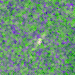

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

sample = train_dataset.__getitem__(91)
img = sample['img']
"""
plt.imshow(img)
print(sample['label'])
"""
imgbytes = (img * 255).astype('uint8')
# print((img * 255).astype('uint8'))
image = PIL.Image.fromarray(imgbytes, 'RGB')
image

In [25]:
ensem_dataset.data

,band_1,band_2,id,inc_angle,is_iceberg
1283,"[-20.993998, -22.486746, -22.132248, -20.54870...","[-26.008495, -26.863613, -24.07045, -25.230366...",92724245,32.785,1
1284,"[-18.400486, -17.917862, -16.314745, -16.71421...","[-24.176397, -22.433443, -21.860588, -23.04691...",86de6cf4,41.8304,0
1285,"[-23.845499, -24.58, -22.540255, -23.168468, -...","[-30.600555, -32.93071, -32.930756, -31.12727,...",8fc1d7a9,42.5644,1
1286,"[-25.82966, -26.428976, -27.413387, -26.429077...","[-21.568163, -24.246084, -25.001907, -25.26923...",083a41f9,40.9858,0
1287,"[-19.514771, -17.125294, -15.077877, -15.25339...","[-22.408426, -21.82268, -22.612892, -24.974918...",4071fcf3,43.9873,0
1288,"[-10.451881, -10.041515, -10.882811, -13.30024...","[-21.356623, -22.400249, -22.973223, -22.40038...",c8de125d,35.713,0
1289,"[-15.622065, -14.756765, -13.834206, -11.33550...","[-25.675573, -26.503502, -22.604044000000002, ...",56426f39,33.634,1
1290,"[-24.50528, -27.427891, -27.087276, -27.78257,...","[-28.942253, -26.759417, -26.138783, -27.42799...",ae0cd7f9,na,0
1291,"[-21.213083, -22.278049, -23.93759, -23.068333...","[-28.684696, -27.928982, -28.298706, -25.99089...",15dd8345,38.8999,0
1292,"[-20.866539, -18.329008, -16.745317, -15.91739...","[-22.961246, -21.344717, -21.182291, -21.02284...",f6c28085,35.7991,0


In [26]:
valid_dataset.data

,band_1,band_2,id,inc_angle,is_iceberg
1443,"[-21.861492, -18.511742, -20.895542, -23.75743...","[-26.764935, -24.648933, -22.757885, -24.19182...",74ca6838,34.0453,0
1444,"[-19.024738, -18.649811, -17.613239, -18.77314...","[-27.047642, -23.853685, -24.548988, -27.37563...",cc28a327,37.3218,0
1445,"[-14.815742, -13.03135, -14.015712, -13.476949...","[-21.802437, -21.306036, -20.247314, -25.07262...",546c9a11,34.4709,1
1446,"[-22.548616, -20.365765, -21.571722, -24.91071...","[-25.471174, -25.186405, -26.386404, -27.05491...",558288bf,45.1238,0
1447,"[-22.232338, -19.500736, -19.639769, -21.50825...","[-24.361443, -26.544388, -27.528803, -26.54449...",598b87f2,39.591,1
1448,"[-25.637905, -25.094913, -27.506447, -23.64400...","[-25.362139, -26.52203, -26.522085, -26.217339...",457f6c59,39.2325,1
1449,"[-29.562782, -27.903343, -28.693558, -28.6936,...","[-29.562782, -31.616074, -34.310089, -32.21542...",591c1990,43.2263,0
1450,"[-18.616344, -16.179014, -13.634161, -17.26007...","[-27.014236, -25.011993, -25.271292, -27.34216...",e4c12020,37.6866,1
1451,"[-21.752052, -24.636971, -25.759327, -24.63704...","[-30.924809, -34.179394, -26.707821, -26.70785...",8cb77cca,45.2814,1
1452,"[-18.52878, -17.601404, -18.287546, -22.112103...","[-25.726711, -24.924366, -24.924423, -26.01163...",af23f247,38.458,1


In [42]:
band_1 = np.array(ensem_dataset.data.iloc[0]['band_1']).reshape(75, 75)
print(band_1.max())
print(band_1.min())

-3.733471
-28.880398


In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [11]:
MODEL_STORE_KEY = 'model_state_dict'
OPTIM_STORE_KEY = 'optim_state_dict'
EPOCH_KEY = 'epoch'

class Iceberg:
    
    def __init__(self, dtpath, cppath, model, optim, nepoch):
        """
        cppath: file path for save/resume models
        dtpath: file path for input data
        model: deep learning model, pretrained params loaded
        optim: deep learning optimizer
        nepoch: number of epochs
        """
        # member from constructor params
        self.dtpath = dtpath
        self.cppath = cppath
        self.model = model
        self.optim = optim
        self.nepoch = nepoch
        
        # member to initialize
        self.epoch = 0
        self.bsize = 128
        self.train_btime = AverageMeter()
        self.train_dtime = AverageMeter()
        self.train_loss = AverageMeter()
        self.train_top1 = AverageMeter()
        self.train_top5 = AverageMeter()
        
        # other initilization
        self.resume()
        
    def resume(self):
        if os.path.isfile(self.cppath):
            print("=> loading checkpoint '{}'".format(self.cppath))
            cp = torch.load(self.cppath)
            self.model.load_state_dict(cp[MODEL_STORE_KEY])
            self.optim.load_state_dict(cp[OPTIM_STORE_KEY])
            self.epoch = cp[EPOCH_KEY]
            print("=> loaded checkpoint '{}' (epoch {})".format(self.cppath, self.epoch))
            
    def store(self):
        state = {
            EPOCH_KEY: self.epoch,
            MODEL_STORE_KEY: self.model.state_dict(),
            OPTIM_STORE_KEY: self.optim.state_dict()
        }
        torch.save(state, self.cppath)
    
    def run(self, transform=None):
        """run the training and validate process"""
        train_dataset, _, valid_dataset = splitDataset(self.dtpath, [0.8, 0.9], transform)
        self.train_loader = DataLoader(train_dataset, batch_size=self.bsize, shuffle=False,
            num_workers=0, pin_memory=True, sampler=None)
        self.valid_loader = DataLoader(valid_dataset, batch_size=self.bsize, shuffle=False,
            num_workers=0, pin_memory=True, sampler=None)
        
        # To think: should I use some other loss function?
        self.criterion = nn.CrossEntropyLoss().cuda()
        
        stepoch = self.epoch
        for epoch in range(stepoch, self.nepoch):
            self.epoch = epoch
            
            # train for one epoch
            self.train()
            
            # evaluate on validation set
            p1 = self.validate()
            
            # save check point
            self.store()
    
    def infer(self, ttpath):
        pass
    
    def train(self):
        
        # switch to train mode
        self.model.train()

        end = time.time()
        for i_batch, sample_batched in enumerate(self.train_loader):
            """Start batch train"""
            var_images = torch.autograd.Variable(sample_batched['img'].cuda())
            tensor_target = sample_batched['label'].cuda()
            var_target = torch.autograd.Variable(tensor_target)
            logits = self.model(var_images)
            loss = self.criterion(logits, var_target)
        
            prec1, prec5 = self.accuracy(logits.data, tensor_target, topk=(1, 5))
            batch_size = sample_batched['label'].size(0)
            self.train_loss.update(loss.data[0], batch_size)
            self.train_top1.update(prec1[0], batch_size)
            self.train_top5.update(prec5[0], batch_size)
        
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
        
            self.train_btime.update(time.time() - end)
            end = time.time()
        
            if i_batch % 2 == 0:
                print('Epoch: [{0}][{1}/{2}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                      'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                       self.epoch, i_batch, len(self.train_loader),
                       batch_time=self.train_btime, loss=self.train_loss,
                       top1=self.train_top1, top5=self.train_top5))
    
    def validate(self):
        pass
    
    def accuracy(self, output, target, topk=(1,)):
        """Computes the precision@k for the specified values of k"""
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [12]:
from models.resnet import resnet18

model = resnet18().cuda()
optim = torch.optim.SGD(model.parameters(), 0.0005, momentum=0.9, weight_decay=1e-4)

iceberg = Iceberg('./data/train.json', './data/model.pth', model, optim, 100)
iceberg.run(transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()]))

=> loading checkpoint './data/model.pth'
=> loaded checkpoint './data/model.pth' (epoch 2)
Epoch: [2][0/11]	Time 2.973 (2.973)	Loss 0.6825 (0.6825)	Prec@1 58.594 (58.594)	Prec@5 100.000 (100.000)
Epoch: [2][2/11]	Time 1.694 (2.117)	Loss 0.6740 (0.6738)	Prec@1 55.469 (59.115)	Prec@5 100.000 (100.000)
Epoch: [2][4/11]	Time 1.915 (1.986)	Loss 0.6739 (0.6778)	Prec@1 54.688 (57.344)	Prec@5 100.000 (100.000)


KeyboardInterrupt: 

In [3]:
import torch

a = torch.randn(10, 5)
a


 0.6463 -0.4428 -0.9667  0.0395 -0.1159
-0.5906 -0.0802 -0.5795 -0.8966  0.2161
-1.3495 -0.0758  0.4543  0.2349 -0.3237
 0.0283  0.4157  0.6662 -1.0264 -1.4214
-1.1003  0.6608  0.7660  0.3839 -1.0200
-0.1478  1.3692  0.9001  0.6749 -0.1402
 0.4807  1.8759  1.4919  0.5988  1.7299
 0.9392 -1.3553 -0.4283  0.5254 -0.8835
 2.0502 -2.4792 -1.0897  1.3844 -0.9440
 0.0690 -0.5470 -1.2994  0.3992 -0.8636
[torch.FloatTensor of size 10x5]

In [9]:
a[:, 0:2]


 0.6463 -0.4428
-0.5906 -0.0802
-1.3495 -0.0758
 0.0283  0.4157
-1.1003  0.6608
-0.1478  1.3692
 0.4807  1.8759
 0.9392 -1.3553
 2.0502 -2.4792
 0.0690 -0.5470
[torch.FloatTensor of size 10x2]

In [31]:
exp_a = torch.exp(a[:, 0:2])
b = exp_a[:, 1] / torch.sum(exp_a, 1)
s = ['d0','d1','d2','d3','d4','d5','d6','d7','d8','d9']

import pandas as pd
df = pd.DataFrame({
    'id': s,
    'is_iceberg': b
})
df

,id,is_iceberg
0,d0,0.251800
1,d1,0.624886
2,d2,0.781368
3,d3,0.595650
4,d4,0.853340
5,d5,0.820103
6,d6,0.801411
7,d7,0.091574
8,d8,0.010672
9,d9,0.350709


In [24]:
import numpy as np
np.exp([-0.4, 0.6])

array([ 0.67032005,  1.8221188 ])

In [32]:
logits = torch.load('/home/iceberg/data/resnet18_lr5e-4_mom9e-1_wd1e-4_bs256_model/logits.tensor')

In [34]:
logits[:, 0:2]


  16.3550    6.7902
  14.5761    8.8291
   5.2223   36.4132
         ⋮          
  11.0948   19.1687
  19.3211    4.3504
  14.1867   11.6824
[torch.cuda.FloatTensor of size 512x2 (GPU 0)]

In [36]:
exp_logits = torch.exp(logits[:, 0:2])

In [44]:
exp_logits[-30:-20, :]


 5.3619e+05  1.0335e+04
 3.7770e+06  4.8758e+03
 5.6041e+02  1.2887e+13
 1.2533e+04  4.2227e+07
 3.6434e-02         inf
 4.1397e+03  4.5299e+10
 9.3444e+06  4.1848e+02
 1.7155e+06  9.6182e+03
 1.8613e+02  5.1386e+17
 2.6059e+06  5.8904e+03
[torch.cuda.FloatTensor of size 10x2 (GPU 0)]

In [45]:
logits[-30:-20, 0:2]


  13.1922    9.2433
  15.1444    8.4920
   6.3287   30.1872
   9.4361   17.5586
  -3.3122  128.6057
   8.3284   24.5366
  16.0503    6.0366
  14.3552    9.1714
   5.2264   40.7807
  14.7733    8.6811
[torch.cuda.FloatTensor of size 10x2 (GPU 0)]

In [52]:
import torch.nn as nn
from torch.autograd import Variable
softmax = nn.Softmax(dim=1)
y0 = softmax(Variable(logits[-30:-20, 0:2]))
y0

Variable containing:
 0.9811  0.0189
 0.9987  0.0013
 0.0000  1.0000
 0.0003  0.9997
 0.0000  1.0000
 0.0000  1.0000
 1.0000  0.0000
 0.9944  0.0056
 0.0000  1.0000
 0.9977  0.0023
[torch.cuda.FloatTensor of size 10x2 (GPU 0)]

In [58]:
y1 = softmax(Variable(logits))[:,1]
y1

Variable containing:
 7.0144e-05
 3.1807e-03
 1.0000e+00
 2.8858e-02
 2.7811e-03
 1.2887e-02
 3.6180e-03
 2.6671e-03
 6.7568e-03
 5.9128e-08
 9.4377e-06
 1.1360e-03
 1.0336e-04
 1.8673e-03
 1.0000e+00
 9.2907e-07
 1.0000e+00
 5.4293e-01
 1.0000e+00
 9.8832e-01
 1.6796e-04
 7.7942e-04
 1.0000e+00
 4.6717e-06
 1.3489e-05
 3.8007e-02
 1.3700e-01
 6.8628e-01
 9.5769e-01
 1.2294e-02
 2.6113e-04
 1.0000e+00
 5.2995e-07
 2.9811e-01
 8.2873e-04
 9.9999e-01
 3.5491e-03
 1.0000e+00
 9.8878e-01
 9.9703e-01
 1.0000e+00
 9.9939e-01
 6.7644e-08
 3.7087e-03
 1.0000e+00
 8.1628e-01
 6.4682e-04
 1.0000e+00
 9.9984e-01
 1.2262e-03
 4.9608e-08
 9.9999e-01
 1.3128e-03
 1.0000e+00
 1.0000e+00
 9.6272e-01
 2.2552e-05
 3.9138e-03
 4.1331e-06
 7.5473e-05
 6.8945e-02
 7.8633e-05
 6.7140e-01
 5.3460e-03
 9.1262e-07
 9.9611e-01
 3.9764e-04
 2.7679e-02
 1.0000e+00
 4.8653e-01
 3.5958e-02
 5.8494e-06
 7.9011e-01
 9.5429e-01
 9.5032e-01
 1.0000e+00
 5.5167e-04
 2.5957e-03
 6.1774e-01
 1.0000e+00
 8.7815e-01
 5.1443